In [3]:

import urllib.request

import torch

import torch.nn as nn
import tqdm

import numpy as np

import cv2
import imageio
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim

# return type: np.ndarray
def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256

    # set range[0, 255]
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    
    # (h, w, c) -> (c, h, w) 
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def get_image():
    image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'

    # rgb channel, normalize[0,1]
    img = imageio.imread(image_url)[..., :3] / 255.

    # find the center
    c = [img.shape[0] // 2, img.shape[1] // 2]

    # rangeo of pixel
    r = 256

    # ROI
    img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]

    return img

cpu


/var/folders/rt/hdfvhf8d2bv44gz1j9pcy5700000gn/T/ipykernel_94348/3455609630.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


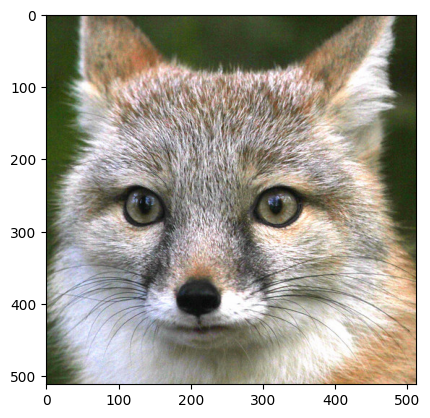

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Get an image that will be the target for our model.
# add a dimension for batch and rearrange
target = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

# Create input pixel coordinates in the unit square. This will be the input to the model.
coords = np.linspace(0, 1, target.shape[2], endpoint=False)
xy_grid = np.stack(np.meshgrid(coords, coords), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, loss = 0.224


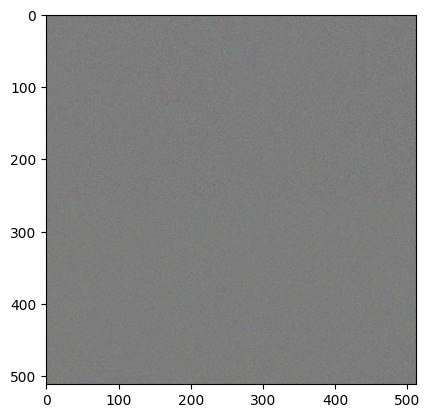

KeyboardInterrupt: 

In [10]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()

        self.flatten = nn.Flatten()

        self.neural_net = nn.Sequential(
            
            # layer 1
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(p = 0.5),

            # layer 2
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(p = 0.5),

            # layer 3
            nn.Linear(hidden_features, out_features),
            nn.Sigmoid()

        )

    def forward(self, x):
        return self.neural_net(x)

# declare network
net = MLP(in_features=2, hidden_features=1024, out_features=3)

# criterion = nn.MSELoss()

model = net



optimizer = optim.Adam(model.parameters(), lr=0.01) 

for epoch in tqdm(range(400)):
    optimizer.zero_grad()
    
    # Reshape xy_grid from (1, 2, 512, 512) to (1*512*512, 2)
    xy_grid_reshaped = xy_grid.view(1*512*512, 2)
    
    # Pass the reshaped tensor through the model
    generated = model(xy_grid_reshaped)
    
    # Reshape the output back to (1, 3, 512, 512)
    generated = generated.view(1, 3, 512, 512)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()

     
model.eval()